# Tree Classification

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from utils.data_loader import DataLoader
from utils.calculate_indices import CalculateIndices
from utils.basic_analysis import BasicDataAnalysis
from utils.visualization_histogram import HistogramDataVisualization
from utils.time_series_aggregate import TimeSeriesAggregate
from utils.visualization_spectral import SpectralBandPlotter

from utils.correlation_analysis import CorrelationAnalysis
from utils.visualization_time_series import plot_date_diff_distribution
from utils.sits_outlier_cleaner import SITSOutlierCleaner

from utils.visualization_spectral import SpectralBandPlotter
from utils.visualization_histogram import HistogramDataVisualization
from utils.visualization_function import (
    plot_intervals_timestamps,
    plot_top_correlations,
    plot_autocorrelation,
    plot_band_differences,
)


In [2]:
dataloader = DataLoader()
df_base = dataloader.load_transform("../../data/raw_trainset.csv")

## Basic Data Analysis

In [ ]:
basicanalysis = BasicDataAnalysis(df_base)
basicanalysis.get_dtypes()

In [ ]:
print(f"Raw Dataset cols:{basicanalysis.get_num_cols()}")
print(f"Raw Dataset rows:{basicanalysis.get_num_rows()}")

In [ ]:
basicanalysis.get_desricption()

In [ ]:
basicanalysis.get_missing_counts()

## Feature Engineering

### Basic Feature Engineering

In [3]:
df = dataloader.feature_extraction(df_base)

### Datetime Feature Engineering

In [4]:
df = dataloader.date_feature_extraction(df)

### Advanced Feature Engineering

In [ ]:
calcindices = CalculateIndices()
df = calcindices.add_all_indices(df)

## Exploratory Data Analysis

### Visualization Base-Dataframe 

In [ ]:
hist = HistogramDataVisualization(df)
hist.plot_unique_ids("year")

In [ ]:
hist.plot_unique_ids("month_num")

In [ ]:
hist.plot_unique_ids("species")

In [ ]:
hist.plot_median_id_distribution()

## Correlation Analysis

In [ ]:
correlation = CorrelationAnalysis(df)
corr_matrix = correlation.get_correlation_matrix()
corr_matrix

In [ ]:
correlation.plot_correlation_matrix()

In [ ]:
top_corr_df = correlation.get_top_correlations(top_n=15)
plot_top_correlations(top_corr_df)

In [ ]:
correlation.plot_correlation_distribution(sample_size=100)

## Disturbed

In [ ]:
unique_values = df["disturbance_year"].unique()
print(f"Nunique: {len(unique_values)}")
print(f"Unique Values:\n{unique_values}")

In [ ]:
dist_disturbance_df = df["is_disturbed"].value_counts().reset_index()
dist_disturbance_df.columns = ["is_disturbed", "count"]


plt.figure(figsize=(8, 5))
plt.bar(dist_disturbance_df["is_disturbed"].astype(str), dist_disturbance_df["count"])
plt.xlabel("Disturbed")
plt.ylabel("Count")
plt.title("Comparison of distrubed values")
plt.grid()
plt.show()


In [ ]:
filtered = df[df["disturbance_year"] != 0]
crosstab = pd.crosstab(filtered["disturbance_year"], filtered["species"])
crosstab.plot(kind="bar", stacked=True, figsize=(10, 6))

plt.xlabel("Disturbance Year")
plt.ylabel("Anzahl")
plt.title("Distribution of Disturbance Year by Species")
plt.legend(title="Species")
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
test = df[df["is_disturbed"]].copy()
test["disturbance_year_diff"] = test["disturbance_year"] - test["year"]
test

In [ ]:
import matplotlib.pyplot as plt

# Werte vorbereiten
values = test["disturbance_year_diff"].dropna()

fig = plt.figure(figsize=(10, 6))
grid = fig.add_gridspec(2, 1, height_ratios=[1, 4], hspace=0.05)
ax_box = fig.add_subplot(grid[0, 0])
ax_box.boxplot(values, vert=False, patch_artist=True)
ax_box.set(xticks=[], xlabel="")
ax_box.set_yticks([])
ax_box.set_title("Distribution of Disturbance Year Differences")
ax_hist = fig.add_subplot(grid[1, 0])
ax_hist.hist(values, bins=30, alpha=0.7, edgecolor="black")
ax_hist.set_xlabel("disturbance_year_diff")
ax_hist.set_ylabel("Frequency")
ax_hist.grid()
plt.show()


In [ ]:
filtered.sort_values(by="disturbance_year", ascending=True)

In [ ]:
filtered = df[df["disturbance_year"] != 0]
id_df = filtered[filtered["id"] == 11759]
id_df

In [ ]:
band_columns = [col for col in id_df.columns if col.startswith("b")]
fig = px.line(id_df, x="time", y=band_columns, markers=":")
fig.show()

## Explore Spectral

In [ ]:
spectral = SpectralBandPlotter(df)
spectral.plot_all_years(sample_size=500, showfliers=True)

In [ ]:
spectral.plot_per_year(sample_size=500)

In [ ]:
spectral.plot_species_season_distribution()

## Time Series Analysis

In [ ]:
plot_date_diff_distribution(df)

In [ ]:
ts_agg = TimeSeriesAggregate(id_df)
df_2w = ts_agg.aggregate_timeseries(freq="2W", method="median")
dataloader = DataLoader()
df_2w_features = dataloader.date_feature_extraction(df_2w)

In [ ]:
spectral = SpectralBandPlotter(df_2w_features)
spectral.plot_spectral_development_over_years(addition="aggregated")

In [ ]:
plot_intervals_timestamps(df_2w_features, addition="aggregated")

### Autocorrelation

In [ ]:
plot_autocorrelation(df_2w_features, "ndvi")

In [ ]:
plot_band_differences(df_2w_features)

In [ ]:
id_df = id_df.reset_index()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


class SITsTimeSeries:
    def __init__(self, df: pd.DataFrame):
        """
        df: DataFrame mit 'time' als Datum und Band-Spalten 'b2'...'b12'
        """
        self.df = df.copy()
        # DatetimeIndex
        self.df["time"] = pd.to_datetime(self.df["time"])
        self.df.set_index("time", inplace=True)
        # Band-Spalten automatisch auswählen
        self.band_cols = [col for col in df.columns if col.startswith("b")]

    def plot_bands(self):
        """Visualisiert alle Bänder"""
        self.df[self.band_cols].plot(figsize=(12, 6), title="SITs Bänder")
        plt.show()

    def adf_test(self):
        """ADF-Test für alle Bänder"""
        results = {}
        for col in self.band_cols:
            result = adfuller(self.df[col])
            results[col] = {
                "ADF-Statistik": result[0],
                "p-Wert": result[1],
                "Stationär": result[1] < 0.05,
            }
        return pd.DataFrame(results).T

    def difference(self, periods=1):
        """Differenzieren aller Bänder"""
        df_diff = self.df[self.band_cols].diff(periods=periods).dropna()
        return SITsTimeSeries(df_diff.reset_index())

    def plot_differenced(self, periods=1):
        """Visualisiert die differenzierte Zeitreihe"""
        diff_obj = self.difference(periods=periods)
        diff_obj.plot_bands()


# Klasse initialisieren
sits_ts = SITsTimeSeries(id_df)
sits_ts.plot_bands()
print(sits_ts.adf_test())

# Differenzierte Bänder visualisieren
sits_ts.plot_differenced()


In [ ]:
df_id = df[df["id"] == 23214].set_index("time")
bands = [col for col in df_id.columns if col.startswith("b")]
stats = df_id[bands].describe().T
print(stats[["mean", "std", "min", "max"]])


In [ ]:
rolling_mean = id_df[bands].rolling(window=3).mean()
rolling_mean.plot(figsize=(12, 5), title="Rolling Mean pro Band")

In [ ]:
from statsmodels.tsa.stattools import adfuller

for col in bands:
    result = adfuller(id_df[col])
    print(f"{col}: p-Wert={result[1]:.3f}, stationär={result[1] < 0.05}")


In [ ]:
df_diff = df_id[bands].diff().dropna()
df_diff.plot(figsize=(12, 5), title="Differenzen der Bänder")


In [ ]:
threshold = df_diff.std() * 2
anomalies = (df_diff.abs() > threshold).any(axis=1)
print("Anomalien erkannt an Tagen:")
df_diff[anomalies]


In [ ]:
print(threshold)

In [ ]:
df_sample = df.sample(100000)
df_sample

In [ ]:
import pandas as pd
import numpy as np


def mark_outliers(df, band_cols=None, threshold=2):
    """
    Markiert Ausreißer in einer multivariaten Zeitreihe pro ID.

    df: DataFrame mit 'id', 'time' und Band-Spalten
    band_cols: Liste der zu prüfenden Bänder, sonst automatisch b2-b12
    threshold: z-score Schwellenwert
    """
    df = df.copy()
    if band_cols is None:
        band_cols = [col for col in df.columns if col.startswith("b")]

    df["is_outlier"] = False  # Standard False

    for id_val, group in df.groupby("id"):
        group = group.sort_values("time")
        # z-score pro Band
        z_scores = (group[band_cols] - group[band_cols].mean()) / group[band_cols].std()
        # Zeilen, in denen irgendein Band über threshold
        outlier_mask = (z_scores.abs() > threshold).any(axis=1)
        df.loc[group.index, "is_outlier"] = outlier_mask

    return df


df_outliers = mark_outliers(df_sample, threshold=2)
df_outliers


In [ ]:
df_ = df[df["id"] == 3439]
band_cols = [col for col in df.columns if col.startswith("b")]
px.line(df_, y=band_cols, x="time", markers="o")

In [ ]:
def mark_outliers_with_details(df, band_cols=None, threshold=2):
    """
    Markiert Ausreißer in einer multivariaten Zeitreihe pro ID
    und gibt Details, welches Band den Ausreißer verursacht.
    """
    df = df.copy()
    if band_cols is None:
        band_cols = [col for col in df.columns if col.startswith("b")]

    df["is_outlier"] = False
    df["outlier_bands"] = None
    df["max_z_score"] = np.nan

    for id_val, group in df.groupby("id"):
        group = group.sort_values("time")
        # Z-Scores berechnen
        z_scores = (group[band_cols] - group[band_cols].mean()) / group[band_cols].std()
        # Zeilen mit Ausreißer
        outlier_mask = z_scores.abs() > threshold
        df.loc[group.index, "is_outlier"] = outlier_mask.any(axis=1)

        # Welche Bänder verursachen Ausreißer
        df.loc[group.index, "outlier_bands"] = outlier_mask.apply(
            lambda row: list(row[row].index) if row.any() else [], axis=1
        )
        # Maximaler Z-Score pro Zeile (absolut)
        df.loc[group.index, "max_z_score"] = z_scores.abs().max(axis=1)

    return df


band_cols = [col for col in df_sample.columns if col.startswith("b")]
df_outliers_detail = mark_outliers_with_details(
    df_sample, band_cols=band_cols, threshold=2
)

# Ausgabe
print(df_outliers_detail[["time", "id", "is_outlier", "outlier_bands", "max_z_score"]])


In [ ]:
id_3499 = df_outliers_detail[df_outliers_detail["id"] == 3439].sort_values(
    by="time", ascending=True
)
id_3499

In [ ]:
outlier_counts = df_outliers_detail.groupby("id")["is_outlier"].sum()
outlier_counts

In [ ]:
import plotly.express as px

# Band-Spalten automatisch auswählen
band_cols = [col for col in id_3499.columns if col.startswith("b")]

# Angenommen, df_ hat schon eine Spalte 'is_outlier' (True/False)
# Wir erstellen einen Scatter für Ausreißer
for band in band_cols:
    df_["value"] = df_[band]  # px.line braucht eine Spalte für y
    fig = px.line(df_, x="time", y="value", markers=True, title=f"Band {band}")

    # Punkte markieren, die Ausreißer sind
    outliers = id_3499[id_3499["is_outlier"]]
    fig.add_scatter(
        x=outliers["time"],
        y=outliers[band],
        mode="markers",
        marker=dict(color="red", size=10),
        name="Outlier",
    )
    fig.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Angenommen, df_ enthält schon die Spalte 'is_outlier'
df_ = df[df["id"] == 3439].copy()
band_cols = [col for col in df_.columns if col.startswith("b")]

# Daten ins "long format" bringen
df_long = df_.melt(
    id_vars=["time", "is_outlier"],
    value_vars=band_cols,
    var_name="band",
    value_name="value",
)

# Plot erstellen
fig = px.line(
    df_long,
    x="time",
    y="value",
    color="band",
    markers=True,
    title="Zeitreihe aller Bänder mit Ausreißermarkierung",
)

# Ausreißerpunkte hinzufügen
outliers = df_long[df_long["is_outlier"]]
fig.add_scatter(
    x=outliers["time"],
    y=outliers["value"],
    mode="markers",
    marker=dict(color="red", size=10, symbol="x"),
    name="Outlier",
)

fig.show()


In [ ]:
counts = df_outliers_detail["is_outlier"].value_counts()
counts


In [5]:
df = df.sort_values(by=["id", "time"])
# 1. Erste 40 eindeutige IDs extrahieren
erste_40_ids = df["id"].drop_duplicates().head(40)

# 2. Alle Zeilen mit diesen IDs auswählen
df_sample = df[df["id"].isin(erste_40_ids)]
df_sample

,time,id,disturbance_year,doy,b2,b3,b4,b5,b6,b7,b8,b8a,b11,b12,species,is_disturbed,month_num,year,season,date_diff
808190,2017-03-13,1,0,72,147,204,145,400,1193,1435,1593,1642,672,347,Norway_spruce_mixed,False,3,2017,Spring,NaN
808191,2017-03-27,1,0,86,137,222,154,389,1247,1561,1557,1747,743,388,Norway_spruce_mixed,False,3,2017,Spring,14.0
808192,2017-04-09,1,0,99,160,248,169,395,1209,1454,1530,1786,674,327,Norway_spruce_mixed,False,4,2017,Spring,13.0
808193,2017-04-22,1,0,112,146,247,152,391,1354,1628,1672,1878,673,305,Norway_spruce_mixed,False,4,2017,Spring,13.0
808194,2017-04-29,1,0,119,171,264,186,419,1353,1731,1806,1938,743,325,Norway_spruce_mixed,False,4,2017,Spring,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148359,2022-08-20,40,0,232,165,255,180,428,1252,1702,1784,1781,748,307,Norway_spruce,False,8,2022,Summer,2.0
2148360,2022-10-01,40,0,274,82,173,87,266,975,1338,1345,1421,403,150,Norway_spruce,False,10,2022,Autumn,42.0
2148361,2022-10-08,40,0,281,108,183,101,277,1003,1333,1362,1365,420,176,Norway_spruce,False,10,2022,Autumn,7.0
2148362,2022-10-12,40,0,285,96,170,100,297,972,1248,1358,1402,422,170,Norway_spruce,False,10,2022,Autumn,4.0


In [12]:
spectral_bands = ["b2", "b3", "b4", "b5", "b6", "b7", "b8", "b8a", "b11", "b12"]

# Clean the data
cleaner = SITSOutlierCleaner(contamination=0.05)
cleaned_df = cleaner.fit_transform(df_sample, band_columns=spectral_bands)
cleaned_df


,time,id,disturbance_year,doy,b2,b3,b4,b5,b6,b7,...,b2_original,b3_original,b4_original,b5_original,b6_original,b7_original,b8_original,b8a_original,b11_original,b12_original
808190,2017-03-13,1,0,72,147.0,204.0,145.0,400.0,1193.0,1435.0,...,147,204,145,400,1193,1435,1593,1642,672,347
808191,2017-03-27,1,0,86,137.0,222.0,154.0,389.0,1247.0,1561.0,...,137,222,154,389,1247,1561,1557,1747,743,388
808192,2017-04-09,1,0,99,160.0,248.0,169.0,395.0,1209.0,1454.0,...,160,248,169,395,1209,1454,1530,1786,674,327
808193,2017-04-22,1,0,112,146.0,247.0,152.0,391.0,1354.0,1628.0,...,146,247,152,391,1354,1628,1672,1878,673,305
808194,2017-04-29,1,0,119,171.0,264.0,186.0,419.0,1353.0,1731.0,...,171,264,186,419,1353,1731,1806,1938,743,325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148359,2022-08-20,40,0,232,165.0,255.0,180.0,428.0,1252.0,1702.0,...,165,255,180,428,1252,1702,1784,1781,748,307
2148360,2022-10-01,40,0,274,82.0,173.0,87.0,266.0,975.0,1338.0,...,82,173,87,266,975,1338,1345,1421,403,150
2148361,2022-10-08,40,0,281,108.0,183.0,101.0,277.0,1003.0,1333.0,...,108,183,101,277,1003,1333,1362,1365,420,176
2148362,2022-10-12,40,0,285,96.0,170.0,100.0,297.0,972.0,1248.0,...,96,170,100,297,972,1248,1358,1402,422,170


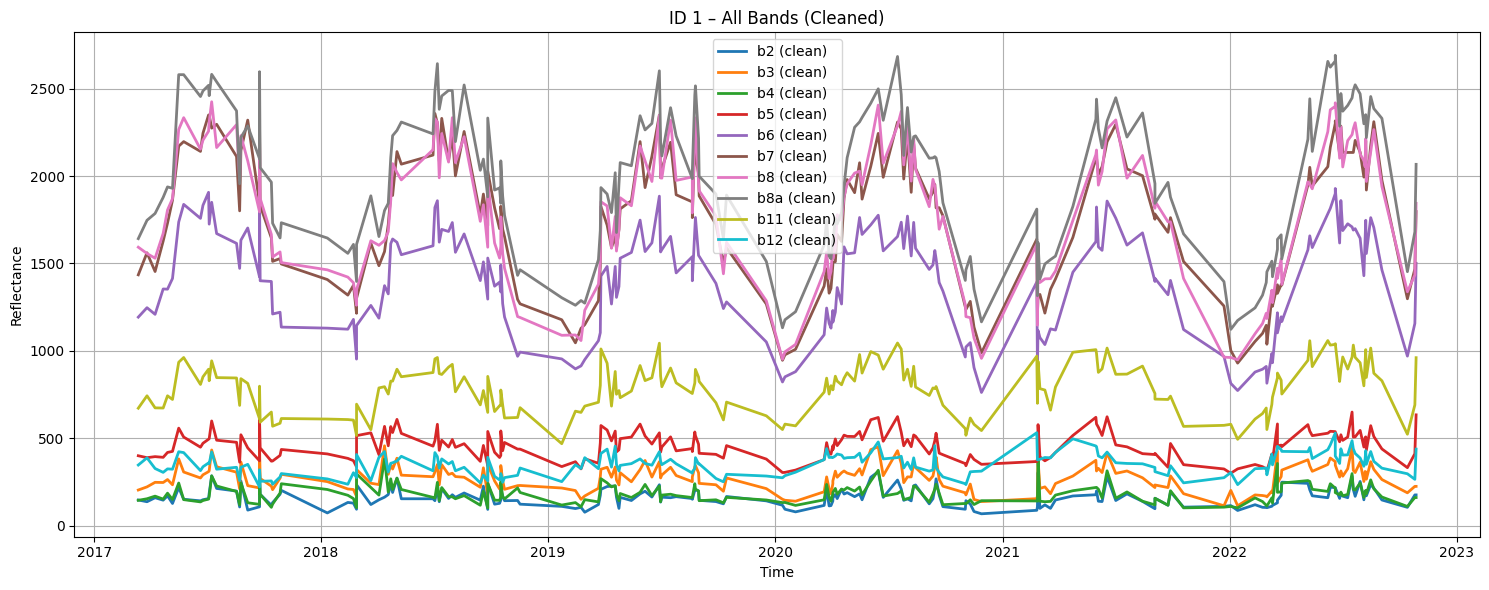

In [13]:
import matplotlib.pyplot as plt

def plot_all_bands(df, id_value, bands):
    df_id = df[df['id'] == id_value].sort_values("time")
    
    plt.figure(figsize=(15, 6))
    
    for band in bands:
        plt.plot(df_id['time'], df_id[band], label=f"{band} (clean)", linewidth=2)
    
    plt.title(f"ID {id_value} – All Bands (Cleaned)")
    plt.xlabel("Time")
    plt.ylabel("Reflectance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_all_bands(cleaned_df, id_value=1, bands=spectral_bands)


In [14]:
import matplotlib.pyplot as plt

def plot_outlier_cleaning(df, sample_id, band):
    df_plot = df[df["id"] == sample_id].sort_values("time")

    plt.figure(figsize=(12, 6))

    # Originalwerte vor der Bereinigung (mit Ausreißern)
    plt.plot(df_plot["time"], df_plot[f"{band}_original"], label="Original", color='gray', linestyle='--', alpha=0.6)

    # Interpolierte Werte nach der Bereinigung
    plt.plot(df_plot["time"], df_plot[band], label="Interpolated (Cleaned)", color='blue')

    # Markiere die detektierten Ausreißer
    outlier_mask = df_plot[f'is_outlier_{band}']
    plt.scatter(
        df_plot["time"][outlier_mask],
        df_plot[f"{band}_original"][outlier_mask],
        label="Detected Outliers",
        color='red',
        marker='x',
        s=100
    )

    plt.title(f"Outlier Detection and Interpolation for ID {sample_id}, Band: {band}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


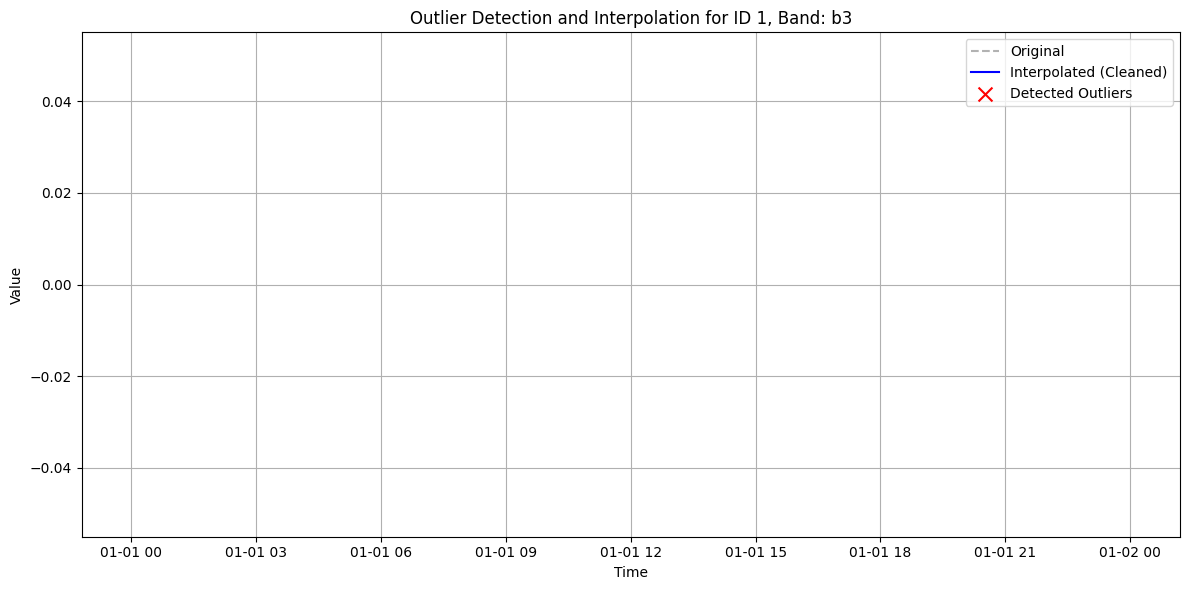

In [18]:
cleaner = SITSOutlierCleaner(contamination=0.05)
cleaned_df = cleaner.fit_transform(df_sample, band_columns=spectral_bands) 

# Dann z.B. für eine id und Band visualisieren
plot_outlier_cleaning(cleaned_df, sample_id='1', band='b3')


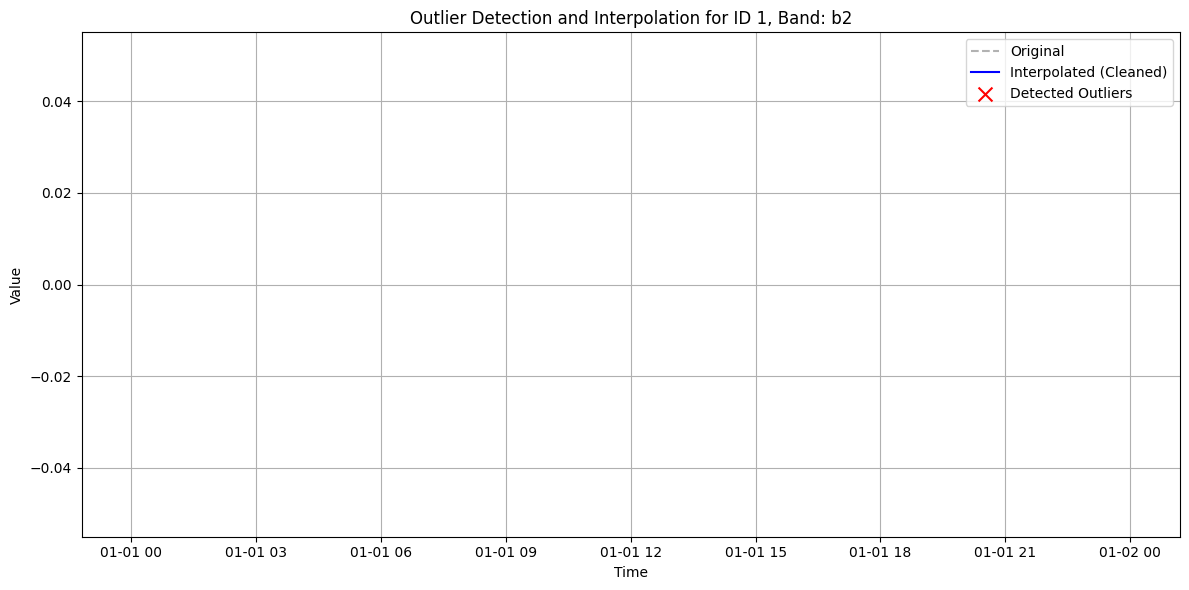

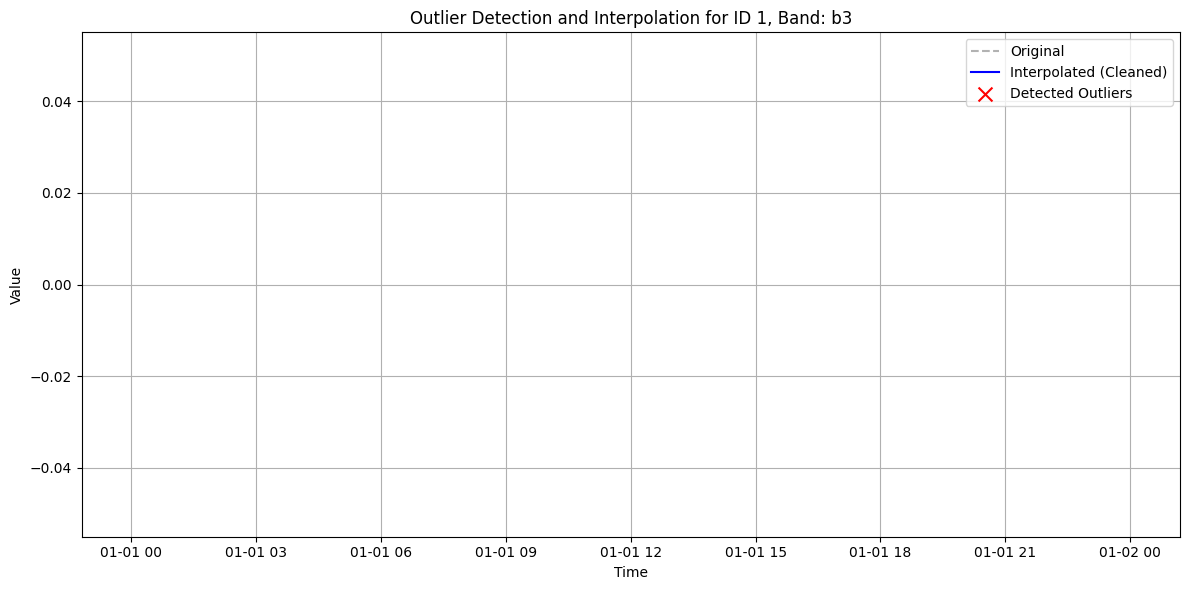

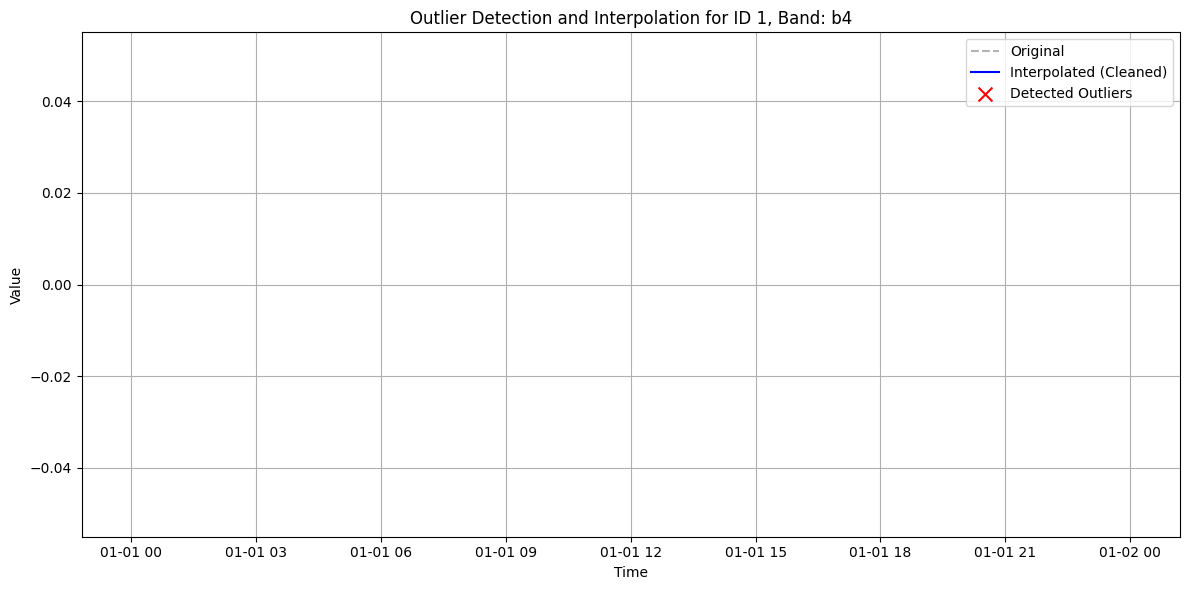

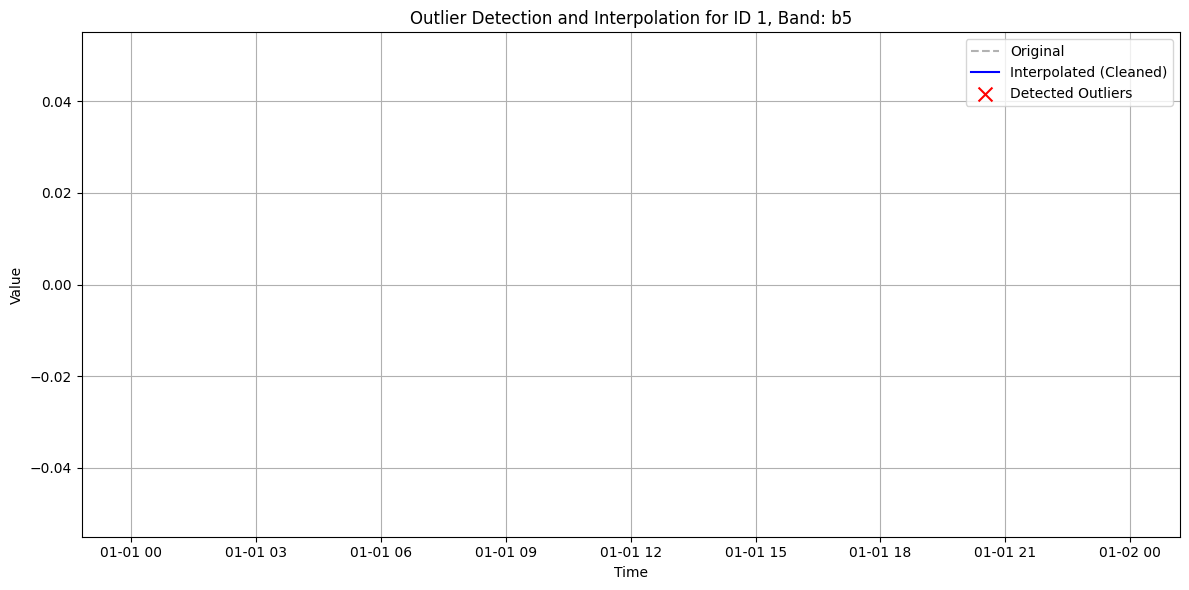

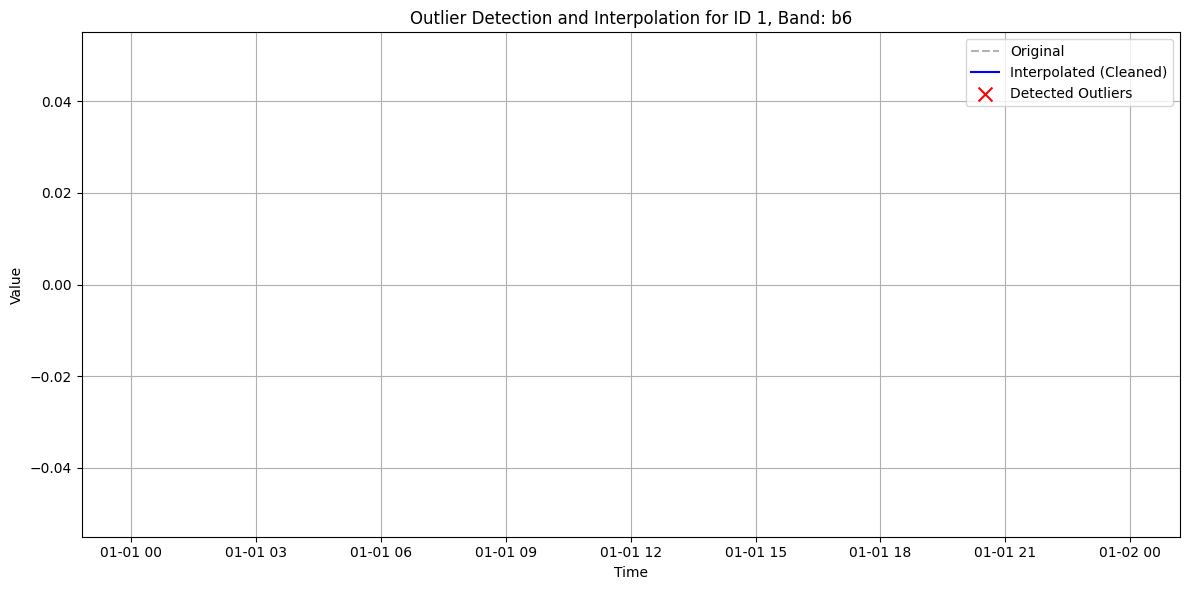

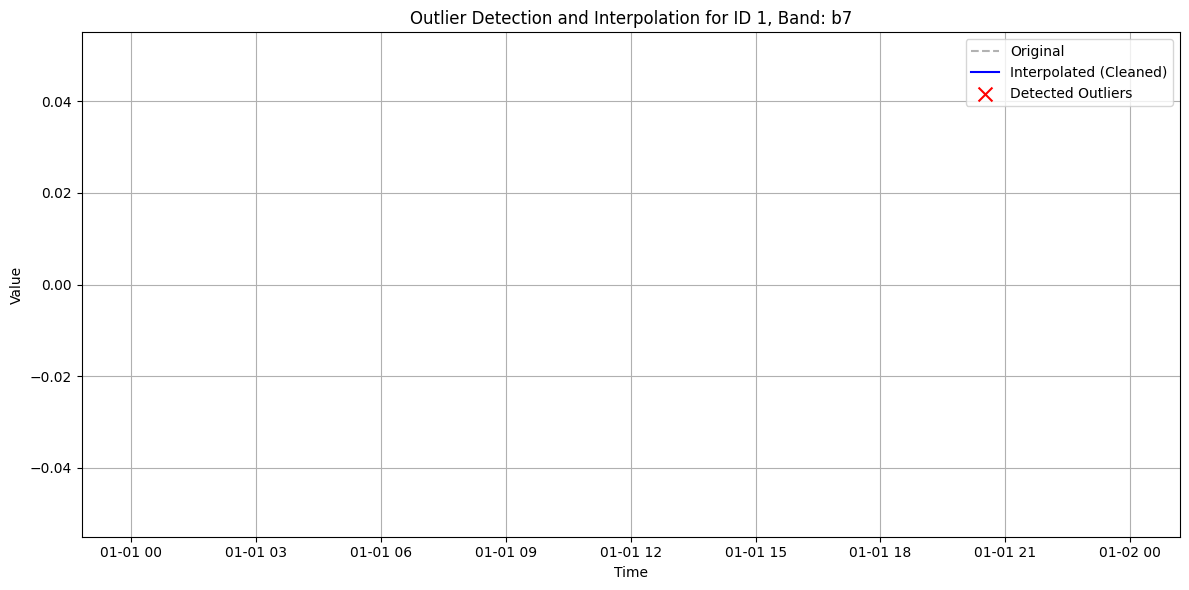

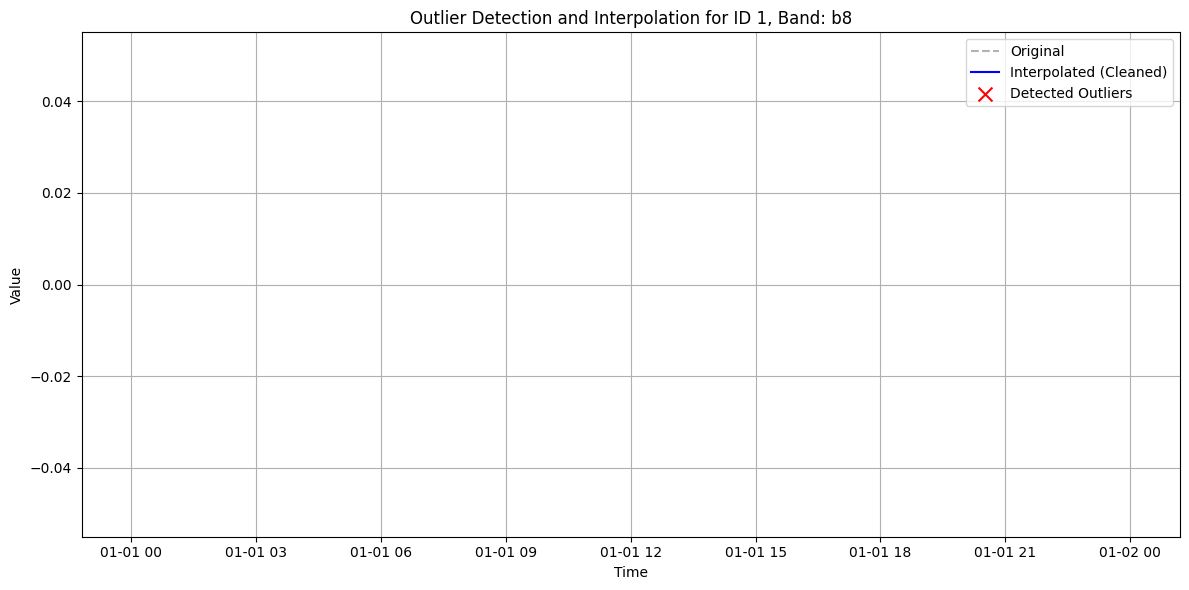

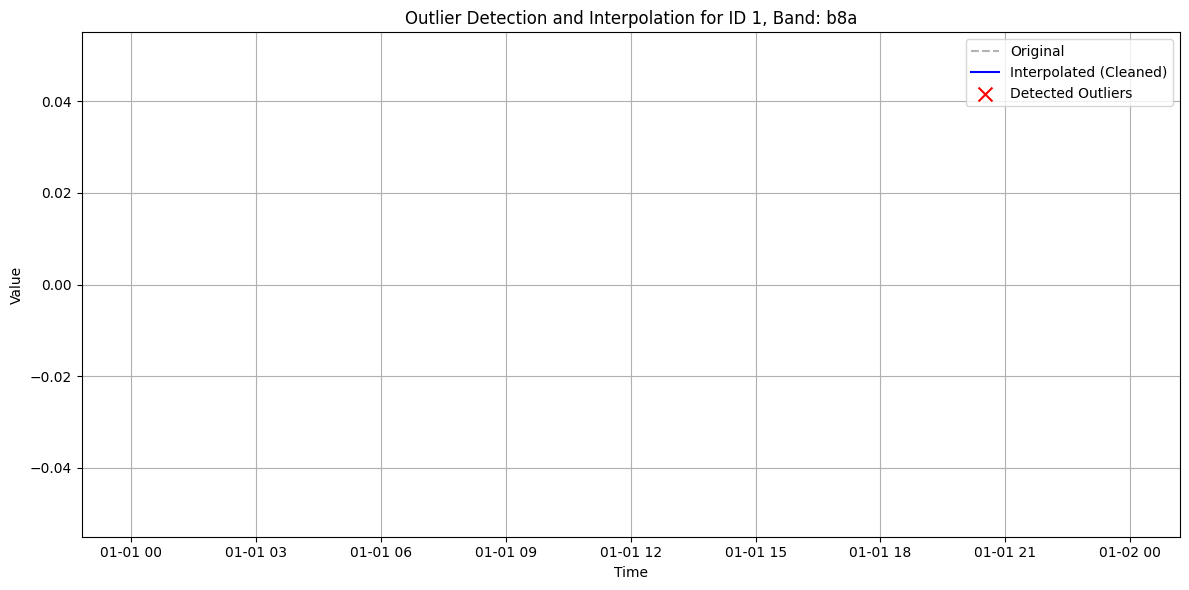

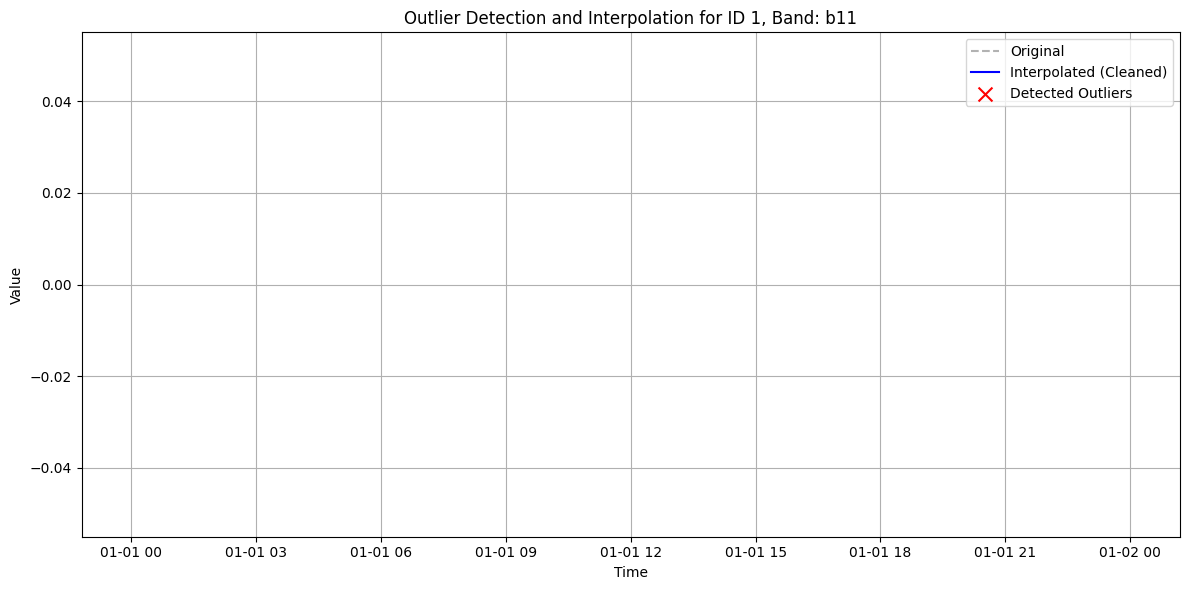

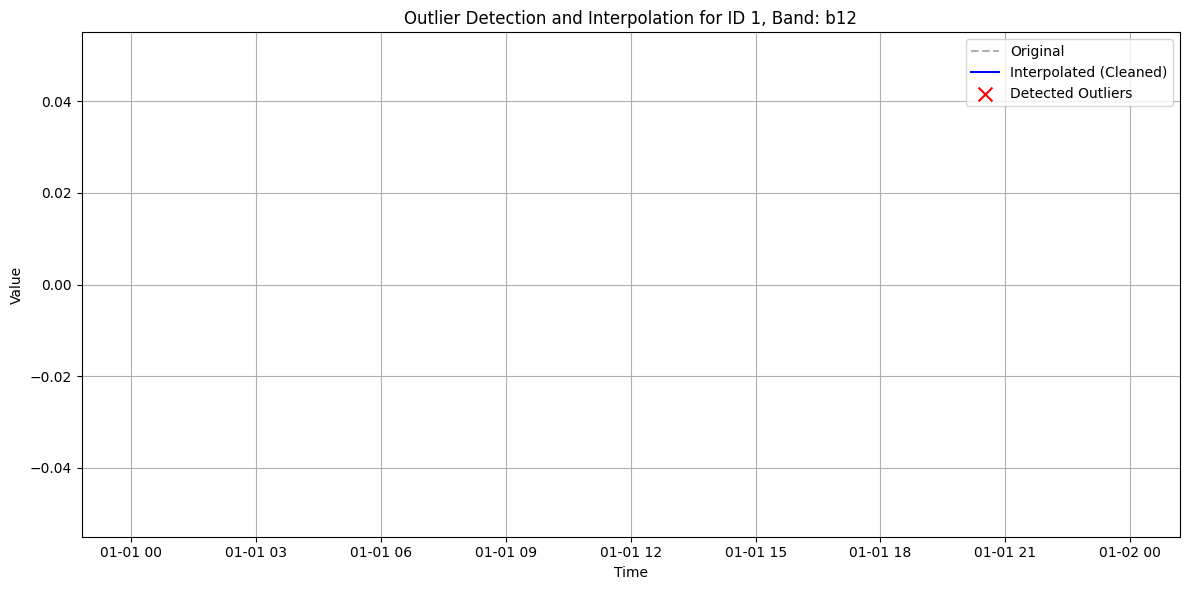

In [19]:
for band in spectral_bands:
    plot_outlier_cleaning(cleaned_df, sample_id='1', band=band)
